# Decomposition of Sky Spectra

This notebook tests the decomposition of sky spectra into continuum and groups of sky lines whose fluxes are tied according to atomic information.

## Read `XCframe` file

And focus on one of the exposure.

In [43]:
from astropy.table import Table
from astropy.io import fits


XCFrame_file = "XCframe_1.1.1_3469_31300_1.fits"
fits.info(XCFrame_file)

tbl = Table.read(XCFrame_file, 'DRP_ALL')
wave = fits.getdata(XCFrame_file, 'WAVE')
flux = fits.getdata(XCFrame_file, 'FLUX')
sky_east = fits.getdata(XCFrame_file, 'SKY_EAST')
sky_west = fits.getdata(XCFrame_file, 'SKY_WEST')

Filename: XCframe_1.1.1_3469_31300_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  WAVE          1 ImageHDU         7   (12401,)   float32   
  2  FLUX          1 ImageHDU        20   (12401, 7947)   float32   
  3  SKY_EAST      1 ImageHDU        20   (12401, 7947)   float32   
  4  SKY_WEST      1 ImageHDU        20   (12401, 7947)   float32   
  5  DRP_ALL       1 BinTableHDU    107   7947R x 49C   [6A, K, K, K, D, K, K, K, 5A, K, 24A, 23A, D, D, D, D, D, D, D, D, D, D, D, D, 13A, D, D, D, D, D, D, D, 13A, D, D, D, D, D, D, D, D, 23A, 77A, 65A, K, 7A, 8A, 8A, D]   


## (OUTDATED, TO BE REMOVED) Prepare Sky Model component calculation

Here two functions are defined to get Sky Model components:

- `get_skymodel_web()` - to call the Web interface

- `get_skymodel()` - to call the locally installed Sky Model

Both functions have `record` as an input parameter - the row in the DRP_ALL table extension.


For `get_skymodel_web` usage, the `skycalc_cli` should be installed:

```bash
pip install skycalc_cli
```

In [4]:
from SkyCalcObs import write_obs_inputs, just_run_SkyCalc_from_observation, reformat2LVM
from SkyModelObs import convert_time
from GetSolar import get_flux

from SkyModelObs import do_one
import os

os.environ['ESO_SKY_MODEL'] = "/Users/ik52/progs/skymodel/"


def get_skymodel_web(record, telescope='sci'):
    """
    Get the sky model for a given record in DRP-like file.

    This is based on the Knox's code https://github.com/kslong/lvm_ksl/blob/main/SkyCalcObs.py
    """

    default = '''
    {
        "ra": 121.75,
        "dec": -29.7,
        "date": "2012-07-17T21:12:14",
        "observatory": "lasilla"
    }
    '''

    time_converted = convert_time(record['obstime'], 'iso_ms')

    skymodel_file = 'test_skycalc'
    skymodel_file_fits = skymodel_file + '.fits'

    if telescope == 'sci':
        ra = record['sci_ra']
        dec = record['sci_dec']
    else:
        NotImplementedError("Only 'sci' telescope is implemented.")

    write_obs_inputs(xdefault=default, ra=ra, dec=dec, xtime=time_converted, msol=-1, outroot=skymodel_file)

    _ = just_run_SkyCalc_from_observation(skymodel_file, almanac='', msol=-1, print_output=False)

    reformat2LVM(skymodel_file_fits)

    return fits.getdata(skymodel_file_fits)


def get_skymodel(record, telescope='sci', output_filename=None):
    """
    Using local Sky Model installation.
    """

    time_converted = convert_time(record['obstime'], 'iso_ms')

    if telescope == 'sci':
        ra = record['sci_ra']
        dec = record['sci_dec']
    elif telescope == 'skye':
        ra =record['skye_ra']
        dec =record['skye_dec']
    elif telescope == 'skyw':
        ra =record['skyw_ra']
        dec =record['skyw_dec']
    else:
        NotImplementedError("Only 'sci' telescope is implemented.")

    if output_filename is not None:
        output_file = do_one(ra=ra, dec=dec, obstime=time_converted, xdata='',
                             config=False, outroot=output_filename)
    else:
        output_file = do_one(ra=ra, dec=dec, obstime=time_converted, xdata='',
                             config=False, outroot='')

    return fits.getdata(output_file)

### Calculate fluxes for all records

First prepare the CSV files with coordinates and observation time for Science, SkyE, and SkyW telescopes.

In [13]:
records_sci = tbl['sci_ra', 'sci_dec', 'obstime']
records_skye = tbl['skye_ra', 'skye_dec', 'obstime']
records_skyw = tbl['skyw_ra', 'skyw_dec', 'obstime']

records_sci.rename_column('sci_ra', 'ra')
records_sci.rename_column('sci_dec', 'dec')

records_skye.rename_column('skye_ra', 'ra')
records_skye.rename_column('skye_dec', 'dec')

records_skyw.rename_column('skyw_ra', 'ra')
records_skyw.rename_column('skyw_dec', 'dec')

records_sci.write('drp_ra_dec_obstime_sci.csv', format='ascii.csv', overwrite=True)
records_skye.write('drp_ra_dec_obstime_skye.csv', format='ascii.csv', overwrite=True)
records_skyw.write('drp_ra_dec_obstime_skyw.csv', format='ascii.csv', overwrite=True)

Now call the `eso_skymodel_eval` CLI tool in batch mode to evaluate ESO Sky Model for all locations of Sci and SkyE and SkyW telescope.

```bash
❯ python -m eso_skymodel_eval batch --csv drp_ra_dec_obstime_sci.csv --ncpu=8 --save-fits skymodel_output_drp1.1.1_sci.fits --ignore-errors
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7947/7947 [03:47<00:00, 34.87it/s]
Completed 7947 records.
Skipped 9 failed record(s) due to errors:
  - idx=104 RA=296.247 Dec=-14.805 ObsTime=2023-08-29T04:27:55.572 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=2407 RA=115.423 Dec=-28.654 ObsTime=2024-02-18T02:36:52.385 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=3117 RA=185.996 Dec=-65.879 ObsTime=2024-03-26T05:15:55.959 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=4136 RA=163.358 Dec=-62.621 ObsTime=2024-06-19T01:48:51.284 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=4147 RA=307.829 Dec=-29.175 ObsTime=2024-06-19T07:22:18.393 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=4169 RA=301.000 Dec=-28.054 ObsTime=2024-06-20T06:04:57.713 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=5516 RA=26.062 Dec=-41.811 ObsTime=2024-08-21T07:28:01.865 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=6477 RA=82.034 Dec=2.566 ObsTime=2024-10-11T05:48:03.556 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=7333 RA=56.920 Dec=-10.702 ObsTime=2024-11-19T02:52:00.905 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
```

Some records caused errors which require further investigation. For now, ignore them.

SkyE:

```bash
❯ python -m eso_skymodel_eval batch --csv drp_ra_dec_obstime_skye.csv --ncpu=8 --save-fits skymodel_output_drp1.1.1_skye.fits --ignore-errors
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7947/7947 [03:56<00:00, 33.63it/s]
Completed 7947 records.
Skipped 21 failed record(s) due to errors:
  - idx=296 RA=2.055 Dec=-34.655 ObsTime=2023-09-22T05:23:09.851 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=923 RA=70.848 Dec=-56.111 ObsTime=2023-11-27T04:43:46.412 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=1170 RA=0.000 Dec=0.000 ObsTime=2023-12-08T05:49:43.264 | Source altitude < 0 deg for RA=0.0, Dec=0.0 at 2023-12-08T05:49:43.264
  - idx=1171 RA=0.000 Dec=0.000 ObsTime=2023-12-08T06:06:23.181 | Source altitude < 0 deg for RA=0.0, Dec=0.0 at 2023-12-08T06:06:23.181
  - idx=1172 RA=0.000 Dec=0.000 ObsTime=2023-12-08T06:23:01.202 | Source altitude < 0 deg for RA=0.0, Dec=0.0 at 2023-12-08T06:23:01.202
  - idx=1173 RA=0.000 Dec=0.000 ObsTime=2023-12-08T06:39:38.625 | Source altitude < 0 deg for RA=0.0, Dec=0.0 at 2023-12-08T06:39:38.625
  - idx=1174 RA=0.000 Dec=0.000 ObsTime=2023-12-08T06:56:22.036 | Source altitude < 0 deg for RA=0.0, Dec=0.0 at 2023-12-08T06:56:22.036
  - idx=1175 RA=0.000 Dec=0.000 ObsTime=2023-12-08T07:20:55.814 | Source altitude < 0 deg for RA=0.0, Dec=0.0 at 2023-12-08T07:20:55.814
  - idx=1176 RA=0.000 Dec=0.000 ObsTime=2023-12-08T07:37:34.750 | Source altitude < 0 deg for RA=0.0, Dec=0.0 at 2023-12-08T07:37:34.750
  - idx=1177 RA=0.000 Dec=0.000 ObsTime=2023-12-08T07:54:18.082 | Source altitude < 0 deg for RA=0.0, Dec=0.0 at 2023-12-08T07:54:18.082
  - idx=1647 RA=105.637 Dec=-36.267 ObsTime=2024-01-04T07:57:08.238 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=2028 RA=134.890 Dec=-43.570 ObsTime=2024-01-30T06:28:23.898 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=2381 RA=118.244 Dec=-24.063 ObsTime=2024-02-17T03:24:50.468 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=2661 RA=88.656 Dec=1.809 ObsTime=2024-03-03T02:13:12.060 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=4195 RA=228.735 Dec=-62.675 ObsTime=2024-06-24T06:41:04.996 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=4846 RA=301.990 Dec=-47.170 ObsTime=2024-07-16T00:50:44.809 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=4881 RA=293.555 Dec=-28.353 ObsTime=2024-07-17T03:15:05.083 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=4882 RA=293.554 Dec=-28.351 ObsTime=2024-07-17T03:31:10.020 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=4949 RA=351.580 Dec=-15.723 ObsTime=2024-07-19T05:32:25.412 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=5544 RA=302.008 Dec=-47.174 ObsTime=2024-08-22T04:59:34.456 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=7331 RA=52.691 Dec=-7.570 ObsTime=2024-11-19T02:17:45.067 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
```

SkyW:

```bash
❯ python -m eso_skymodel_eval batch --csv drp_ra_dec_obstime_skyw.csv --ncpu=8 --save-fits skymodel_output_drp1.1.1_skyw.fits --ignore-errors
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7947/7947 [03:27<00:00, 38.39it/s]
Completed 7947 records.
Skipped 11 failed record(s) due to errors:
  - idx=319 RA=85.792 Dec=-1.270 ObsTime=2023-09-25T06:58:26.561 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=2924 RA=118.233 Dec=-24.060 ObsTime=2024-03-16T01:29:14.054 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=3028 RA=70.871 Dec=-56.146 ObsTime=2024-03-22T00:33:45.240 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=4038 RA=234.750 Dec=-33.430 ObsTime=2024-06-16T02:06:46.059 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=4235 RA=331.976 Dec=-70.730 ObsTime=2024-06-25T07:52:12.563 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=5029 RA=328.218 Dec=-41.760 ObsTime=2024-07-25T07:09:48.379 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=5153 RA=16.350 Dec=-24.239 ObsTime=2024-07-29T09:01:35.298 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=5578 RA=2.046 Dec=-34.642 ObsTime=2024-08-23T06:54:58.218 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=5666 RA=2.054 Dec=-34.653 ObsTime=2024-08-26T06:57:06.123 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=6149 RA=26.956 Dec=-20.527 ObsTime=2024-09-22T06:01:18.163 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
  - idx=6490 RA=2.057 Dec=-34.655 ObsTime=2024-10-12T00:58:43.002 | calcskymodel failed. stderr=[ ERROR ] Dumping all 1 error(s):
[ ERROR ]   [1/1] 'A user-defined error: Invalid input parameter(s): invalid combination of z, zmoon, and rho' (53) at sm_scat_moon:sm_scatmoonlight.c:129
```

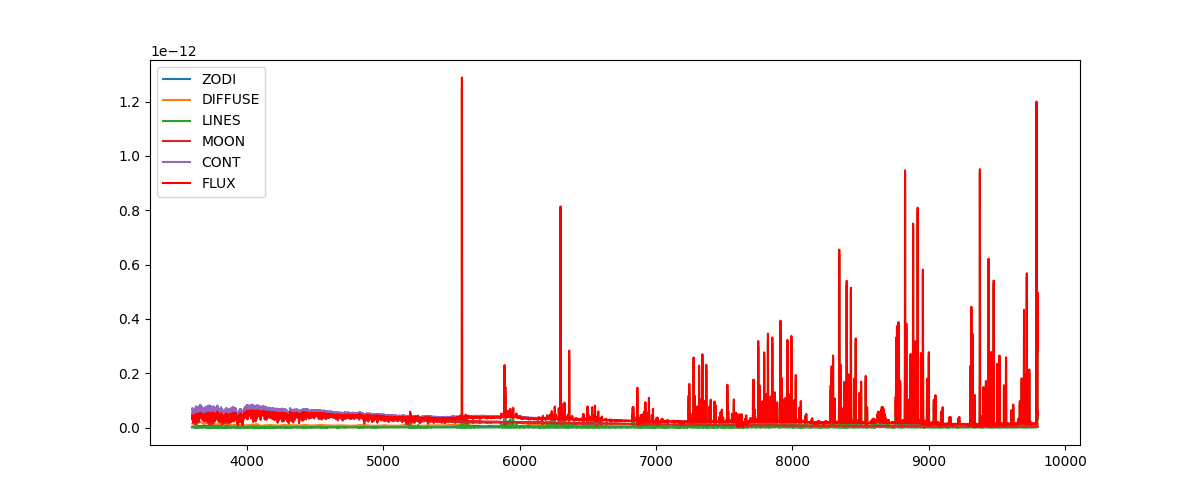

In [44]:
%matplotlib widget
# %matplotlib inline

from matplotlib import pyplot as plt
from astropy.io import fits

f_skye = "skymodel_output_drp1.1.1_skye.fits"
sm_wave = fits.getdata(f_skye, "WAVE")
sm_flux = fits.getdata(f_skye, "FLUX")
sm_moon = fits.getdata(f_skye, "MOON")
sm_zodi = fits.getdata(f_skye, "ZODI")
sm_diffuse = fits.getdata(f_skye, "DIFFUSE")
sm_lines = fits.getdata(f_skye, "LINES")
sm_cont = fits.getdata(f_skye, "CONT")

# Sanuty plots of the evaluated Sky Model
idx = 160
tbl[idx]


plt.figure(figsize=(12, 5))
plt.plot(sm_wave, sm_zodi[idx], label='ZODI')
plt.plot(sm_wave, sm_diffuse[idx], label='DIFFUSE')
plt.plot(sm_wave, sm_lines[idx], label='LINES')
plt.plot(sm_wave, sm_moon[idx], label='MOON')
plt.plot(sm_wave, sm_cont[idx], label='CONT')
plt.plot(sm_wave, sm_flux[idx], label='FLUX', color='red')
plt.legend()
plt.show()

## Prepare Sky Lines

In [39]:
from astropy.table import Table
data = Table.read("lvm_sky_lines_all.dat", format='ascii')
data

wave,flux_lvm,flux_eso,trans,type,electronic_state,rotational_upper_level
float64,float64,float64,float64,int64,int64,int64
3499.769,7.934e-17,0.0013,0.999431,5,39,0
3502.358,6.098e-17,0.001,0.999424,5,41,0
3502.758,7.927e-17,0.0013,0.99943,5,41,0
3504.807,4.875e-17,0.0008,0.999467,5,39,0
3505.317,3.656e-17,0.0006,0.999479,5,41,0
3505.717,7.311e-17,0.0012,0.999482,5,41,0
3508.916,5.478e-17,0.0009,0.999497,5,41,0
3509.846,6.085e-17,0.001,0.999463,5,41,0
3512.116,8.514e-17,0.0014,0.999027,5,41,0


In [40]:
import numpy as np

electronic_state = data['electronic_state'] # fix groups for type!=4,5
type = data['type']

# some adjustments to the electronic state
electronic_state[electronic_state==-999] = type[electronic_state==-999]

lines_groups = []

# iterate over all possivle electronic states
for i in range(0, np.max(electronic_state)):
    state_idx = electronic_state == i
    if not any(state_idx):
        continue

    grp_wave = data['wave'][state_idx]
    grp_flux = data['flux_eso'][state_idx]

    lines_groups.append({
        'wave': grp_wave,
        'flux': grp_flux,
        'electronic_state': i
    })
    print(f"Electronic state {i:3g} --> {len(grp_flux):5g} lines")

print(f"Found {len(lines_groups)} groups of lines")

Electronic state   1 -->    56 lines
Electronic state   2 -->     3 lines
Electronic state   3 -->    23 lines
Electronic state   4 -->     1 lines
Electronic state   5 -->     8 lines
Electronic state   6 -->    22 lines
Electronic state   7 -->    12 lines
Electronic state   8 -->    23 lines
Electronic state   9 -->    41 lines
Electronic state  10 -->    49 lines
Electronic state  11 -->     2 lines
Electronic state  12 -->    27 lines
Electronic state  13 -->    83 lines
Electronic state  14 -->   113 lines
Electronic state  15 -->   111 lines
Electronic state  16 -->    72 lines
Electronic state  17 -->     7 lines
Electronic state  18 -->    85 lines
Electronic state  19 -->   113 lines
Electronic state  20 -->   111 lines
Electronic state  21 -->   110 lines
Electronic state  22 -->   112 lines
Electronic state  23 -->    28 lines
Electronic state  24 -->    74 lines
Electronic state  39 -->   309 lines
Electronic state  40 -->     3 lines
Electronic state  41 -->   337 lines
E

## Create Design matrix

In [41]:
design_matrix_lines = np.zeros((len(lines_groups), wave.size), dtype=float)

lsf_sigma = 1.3 / 2.355

for i, group in enumerate(lines_groups):
    wave_group = group['wave']
    flux_group = group['flux']

    for wave_line, flux_line in zip(wave_group, flux_group):
        if (wave_line >= wave[0]) & (wave_line <= wave[-1]):
            yy = (wave - wave_line) / lsf_sigma
            design_matrix_lines[i] += flux_line * np.exp(-0.5 * yy ** 2) / (np.sqrt(2*np.pi) * lsf_sigma)

## Decomposition

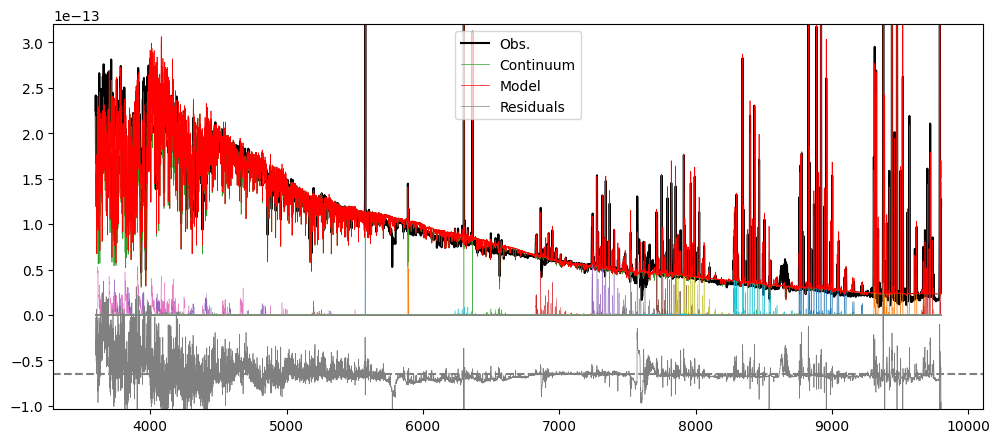

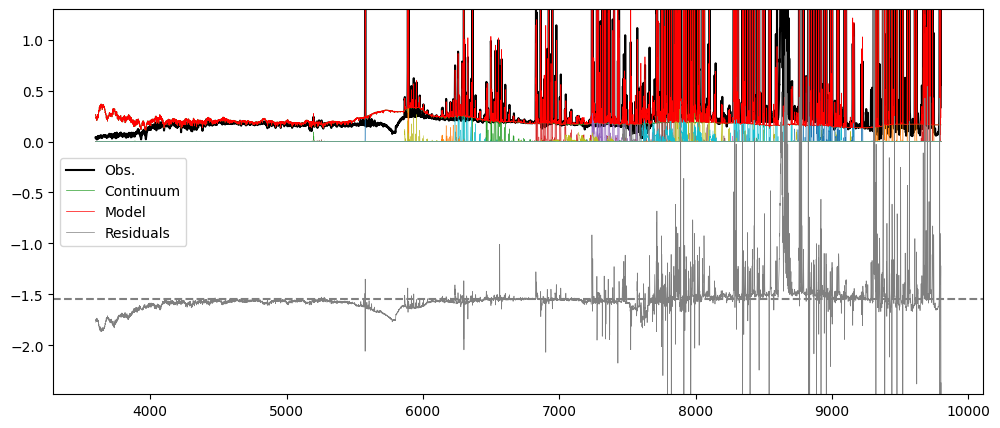

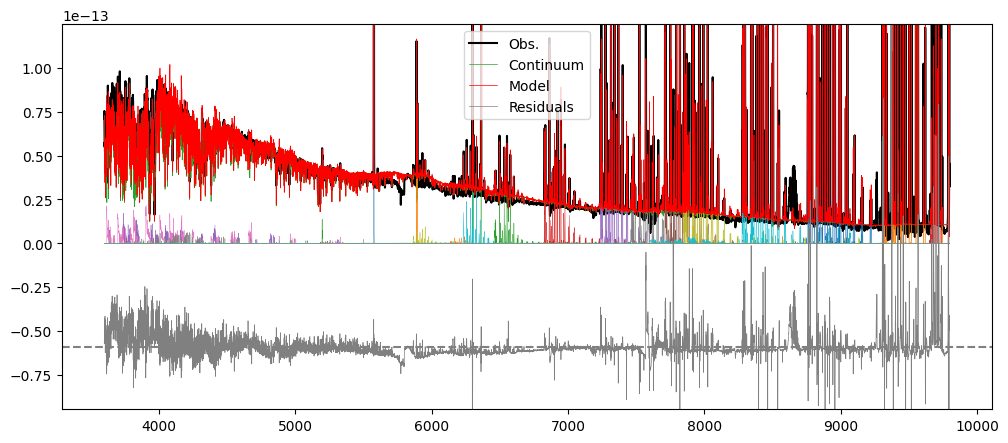

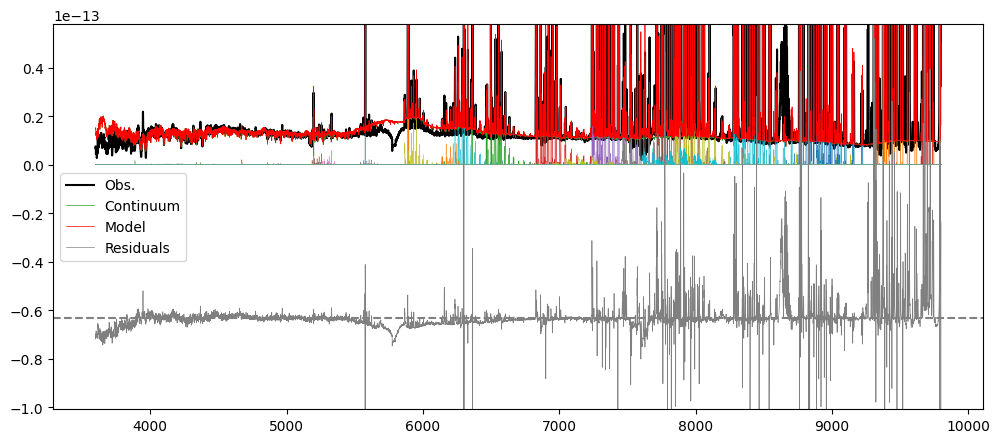

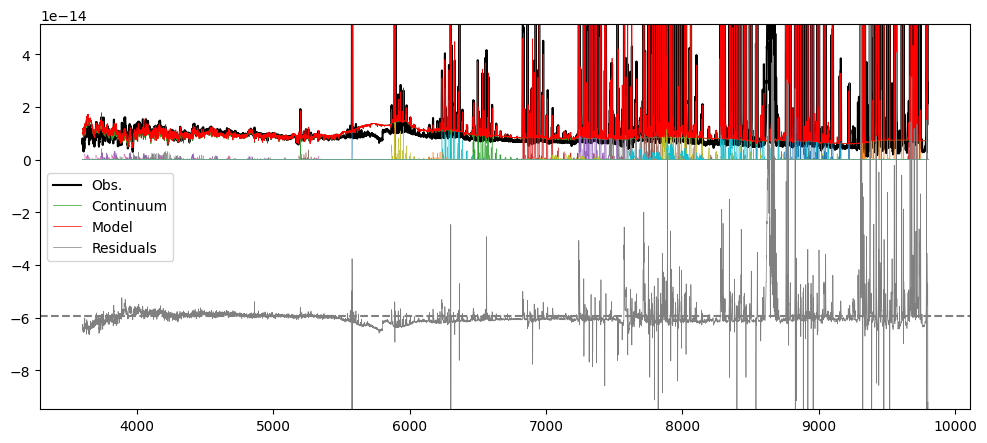

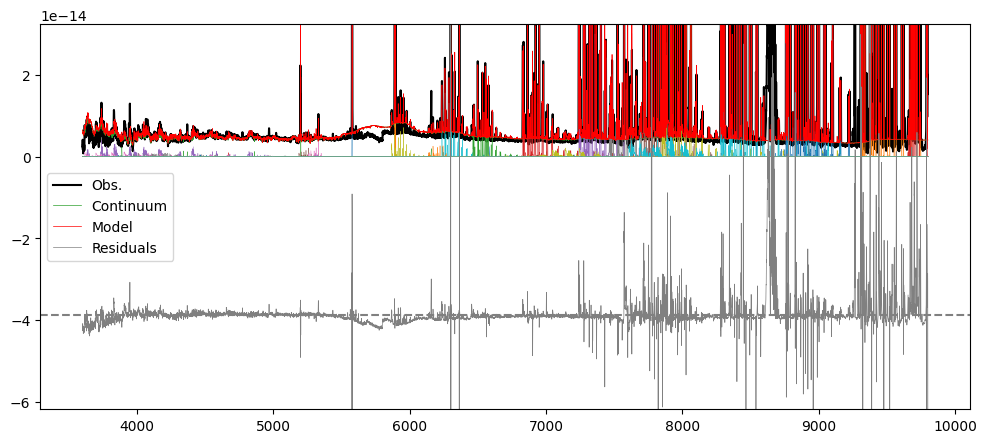

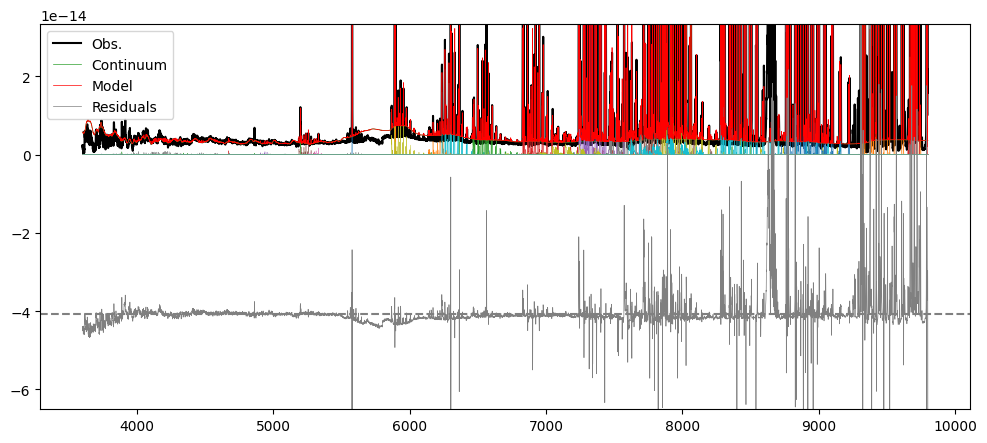

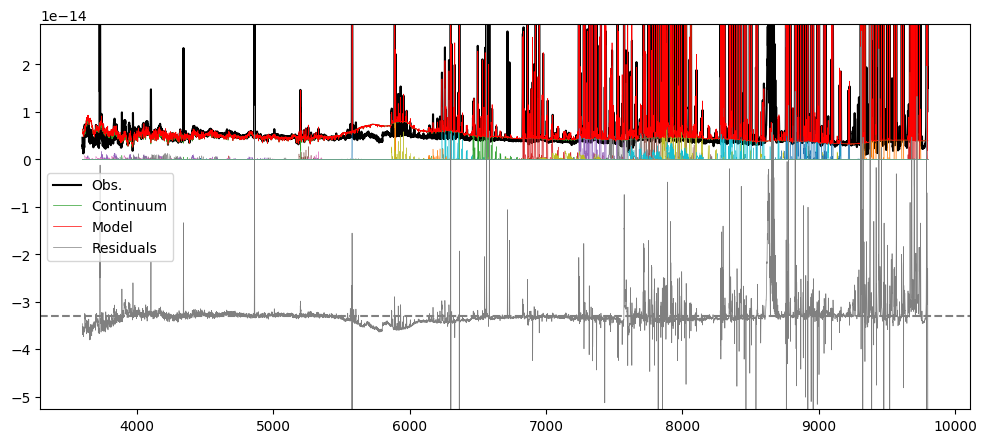

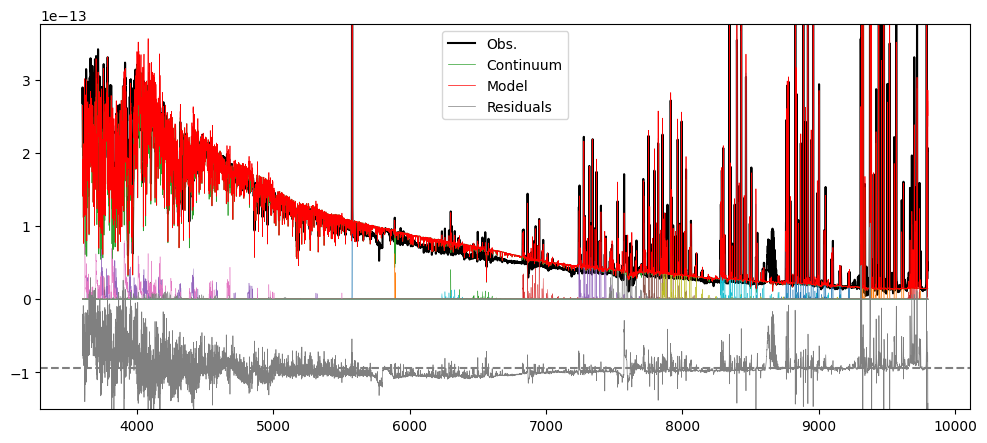

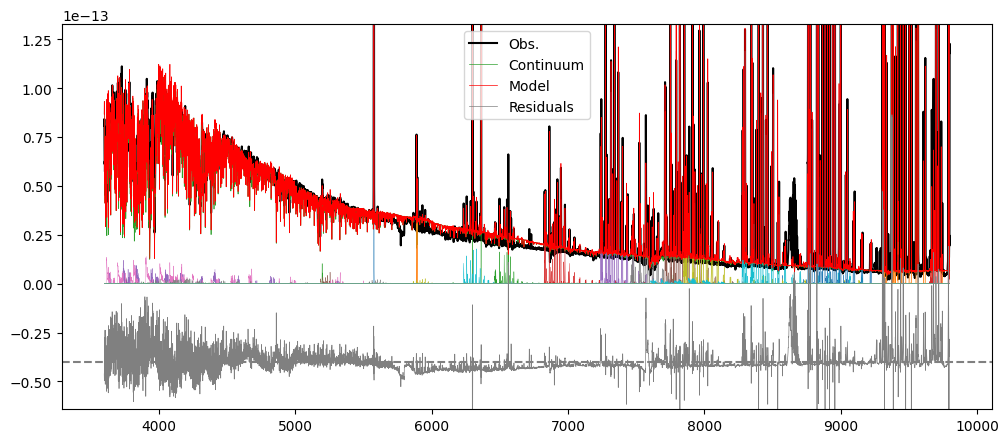

In [58]:
from scipy.optimize import lsq_linear


def decompose_spectrum(spec, continuum_matrix, design_matrix_lines, factor=1e-13, method='separate_cont_comps'):

    if method == 'separate_cont_comps':
        continuum_matrix_updated = continuum_matrix / factor
    else:
        continuum_matrix_updated = np.sum(continuum_matrix, axis=0) / factor

    design_matrix_complete = np.vstack( (design_matrix_lines, continuum_matrix_updated) )

    bounds = (0, np.inf) # requiring only positive values
    results = lsq_linear(design_matrix_complete.T, spec / factor, bounds=bounds)

    coef = results.x * factor

    n_lines = design_matrix_lines.shape[0]

    model_lines = np.dot(design_matrix_complete[:n_lines].T, coef[:n_lines])
    model_cont = np.dot(design_matrix_complete[n_lines:].T, coef[n_lines:])
    
    return model_lines, model_cont, coef

# %matplotlib widget
%matplotlib inline

plt.close('all')
for idx in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:

    spec_obs = sky_east[idx]
    model_lines, model_cont, coef = \
        decompose_spectrum(spec_obs,
                           np.vstack( (sm_moon[idx], sm_zodi[idx], sm_diffuse[idx],) ),
                           design_matrix_lines)

    model = model_lines + model_cont
    resid = spec_obs - model
    rms = np.std(resid)

    plt.figure(figsize=(12, 5))
    plt.plot(wave, spec_obs, color='k', label='Obs.')

    plt.plot(wave, model_cont, color='C2', label='Continuum', lw=0.5)
    
    for i, grp_spec in enumerate(design_matrix_lines):
        plt.plot(wave, grp_spec * coef[i], '-', lw=0.3)

    resid_level = -5 * rms
    plt.axhline(resid_level, color='gray', linestyle='--')
    plt.plot(wave, model, color='red', label='Model', lw=0.5)
    plt.plot(wave, resid_level + resid, color='gray', lw=0.5, label='Residuals')
    plt.ylim(resid_level - 3 * rms, np.max(model_cont) + 3 * rms)
    plt.legend()
    plt.show()

---

## Outdate backups

In [87]:
from numpy.polynomial.legendre import legval
from numpy.polynomial.legendre import legvander

from matplotlib import pyplot as plt
from astropy.convolution import Gaussian1DKernel, convolve

sun, header = fits.getdata("/Users/ik52/sci/IDL_libs/ULySS/v1.3/ulyss/models/sun.fits", header=True)
sun_wave = header['CRVAL1'] + np.arange(len(sun)) * header['CDELT1']

cdelt = header['CDELT1']

lsf_fwhm = 1.5 # in Angstrom
lsf_sigma = lsf_fwhm / 2.35 / cdelt  # in pixels

print("LSF sigma in pixels:", lsf_sigma)

kernel = Gaussian1DKernel(stddev=lsf_sigma, mode='oversample', factor=10)
sun_smoothed = convolve(sun, kernel, boundary='extend')

spec_sun = np.interp(wave, sun_wave, sun_smoothed)

plt.close()
plt.plot(sun_wave, sun)
plt.plot(sun_wave, sun_smoothed, label='smoothed', color='orange')
plt.plot(wave, spec_sun, label='interpolated', color='red')

spec_sun = spec_sun / np.median(spec_sun)

LSF sigma in pixels: 3.191489361702127


In [ ]:
from scipy.optimize import lsq_linear
from numpy.polynomial.legendre import legval
from numpy.polynomial.legendre import legvander


n_order = 13  # maximum Legendre order
x = np.linspace(-1, 1, spec_sun.size)
L = legvander(x, n_order)  # shape (N, n_order+1)
mpoly_basis = (L.T * spec_sun).astype(float)  # shape (n_order+1, N)

design_matrix_complete = np.vstack( (design_matrix, spec_sun) )

factor = 1e-13
# bounds = (0, np.inf)  # non-negative coefficients
bounds = (-np.inf, np.inf)  # allow negative coefficients
results = lsq_linear(design_matrix_complete.T, spec / factor, bounds=bounds)
coef = results.x

model_sun = np.dot(mpoly_basis.T, coef[-n_order-1:])

print(coef)

###############################################################################
# plotting the line groups
model = np.dot(design_matrix_complete.T, coef)
resid = spec / factor - model
rms = np.std(resid)

plt.close()
plt.figure(figsize=(12, 5))
plt.plot(wave, spec / factor, color='k', label='Obs.')

for i, grp_spec in enumerate(design_matrix):
    plt.plot(wave, grp_spec * coef[i], '-')

plt.plot(wave, model_sun, color='C2', label='Sun')
plt.plot(wave, model, color='red', label='Model')

resid_level = -5 * rms
plt.axhline(resid_level, color='gray', linestyle='--')
plt.plot(wave, resid_level + resid, color='gray', lw=0.5, label='Residuals')
plt.legend()
plt.show()